In [1]:
import io, requests, glob, os, math
import sqlite3
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA


In [2]:
# Plot a parameter of a dataframe
def plot_param(params, title, data, log=False):
    params = params if type(params) in (tuple, list) else [params]
    maxDate = data["Datum"].max()
    fig, axs = plt.subplots(5, 2, figsize=(20, 20), constrained_layout=True)
    fig.suptitle(
        f'{title} bis {maxDate.strftime("%d. %b %Y")}',
        fontweight="bold", fontsize="xx-large")
    i = 0

    # Name is the name of the Bundesland. Create a figure for each country.
    for bl in data["Name"].unique():
        data_bl = data.loc[data["Name"] == bl]
        # Figure order: 0  1
        #               2  3 ...
        axis = axs[int(i / 2), i % 2]
        axis.xaxis.set_major_locator(mdates.MonthLocator())
        axis.xaxis.set_minor_locator(
            mdates.WeekdayLocator(byweekday=mdates.MO))
        axis.set_title(bl,
                       fontweight="bold" if bl == "Österreich" else "normal")
        j = 0
        secondAxis = axis.twinx() if len(params) > 1 else None
        # Draw a line for each parameter
        for param in params:
            currentAxis = axis if j == 0 else secondAxis
            if log:
                currentAxis.set_yscale('log')

            res = STL(data_bl.loc[:, param], period=7).fit()
            if j == 0:
                currentAxis.plot(res.observed, linewidth=1)
                currentAxis.plot(res.trend)
            else:
                currentAxis.plot(res.trend, color="black", linewidth=1)
            j = j + 1
        axis.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
        axis.grid(True, which="minor", axis="x")
        axis.grid(True, which="major", axis="y")
        i = i + 1
        if bl == "Österreich":
            for a in ['top', 'bottom', 'left', 'right']:
                axis.spines[a].set_linewidth(2)
            #plt.rc("figure", figsize=(16, 8))
            #res.plot()
    plt.show()
    fig.savefig(f'{title}_{dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d%H%M%S")}.png', facecolor="white", dpi=96)


In [3]:

requests.packages.urllib3.disable_warnings()
requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS += 'HIGH:!DH:!aNULL'

# To avoid ssl error (key to short) we use requests.get
req = requests.get(
    "https://info.gesundheitsministerium.gv.at/data/timeline-faelle-bundeslaender.csv", verify=False)

# Read the result in a dataframe
data = pd.read_table(
    io.StringIO(req.content.decode("utf-8-sig")),
    sep=";", header=0, parse_dates=[0])

with sqlite3.connect("covid.db") as conn:
    data.to_sql(name='DataRaw', con=conn, if_exists='replace', index=False)
    data = pd.read_sql("""
WITH Analyzed AS (
SELECT
    date(Datum, '-1 day') AS Datum,
    BundeslandID, Name, BestaetigteFaelleBundeslaender, Hospitalisierung,
    BestaetigteFaelleBundeslaender - LAG(BestaetigteFaelleBundeslaender, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) AS Neuinfektionen,
    TestungenPCR - LAG(TestungenPCR, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) AS TestungenPCR,
    Hospitalisierung - LAG(Hospitalisierung, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) AS HospitalisierungDiff
FROM DataRaw)
SELECT 
    Datum, BundeslandID, Name, BestaetigteFaelleBundeslaender, Hospitalisierung, HospitalisierungDiff,
    CASE WHEN Neuinfektionen >= 0 THEN Neuinfektionen ELSE NULL END AS Neuinfektionen,
    CASE WHEN TestungenPCR >= 0 THEN TestungenPCR ELSE NULL END AS TestungenPCR,    
    AVG(Neuinfektionen) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS Neuinfektionen7DayAvg,
    AVG(Hospitalisierung) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS Hospitalisierung7DayAvg,
    AVG(TestungenPCR) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS TestungenPCR7DayAvg
FROM Analyzed;
    """, conn)
    for bl in data["Name"].unique():
        for param in ["TestungenPCR", "HospitalisierungDiff", "Hospitalisierung", "Neuinfektionen"]:
            data.loc[data["Name"] == bl, param] = data.loc[data["Name"] == bl, param].interpolate(method="linear")
        # Fill na values for first diff.
        data.loc[data["Name"] == bl] = data.loc[data["Name"] == bl].fillna(method="bfill")
    data.to_sql(name='DataAnalyzed', con=conn, if_exists='replace', index=False)
    conn.execute("VACUUM")


In [4]:
with sqlite3.connect("covid.db") as conn:
    data = pd.read_sql("SELECT * FROM DataAnalyzed ORDER BY Datum, BundeslandId", conn)
    data["Datum"] = pd.to_datetime(data["Datum"])
data.set_index("Datum", drop=False, inplace=True)
for file in glob.glob('*.png'):
    os.remove(file)

## Neuinfektionen

Die Neuinfektionen zeigen eine Abhängigkeit vom Wochentag, da am Wochenende weniger getestet wird. Zudem werden die Schultests an bestimmten Tagen durchgeführt.

In [5]:
neuinfektionen = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "Neuinfektionen": data.tail(7*10)["Neuinfektionen"],
    }
)
neuinfektionen["NeuinfektionenPrint"] = neuinfektionen.apply(lambda x: f'{x.Neuinfektionen:,.0f}'.replace(",", " "), axis=1)
neuinfektionen.pivot(values="NeuinfektionenPrint", columns="Name")


Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-03-02,1 101,2 017,5 812,5 229,2 352,5 376,3 146,1 744,4 789,31 566
2022-03-03,1 094,2 155,7 249,5 736,2 074,4 119,2 550,1 503,5 939,32 419
2022-03-04,1 017,1 890,5 805,5 024,2 500,5 369,2 727,1 635,5 322,31 289
2022-03-05,926,2 093,6 346,4 499,1 539,4 133,2 018,1 426,5 483,28 463
2022-03-06,941,1 555,5 813,4 718,1 373,3 651,1 732,1 361,5 009,26 153
2022-03-07,856,1 382,5 911,4 706,2 372,4 192,3 937,1 743,5 840,30 939
2022-03-08,869,1 617,11 216,9 007,2 868,7 770,3 207,2 286,8 955,47 795


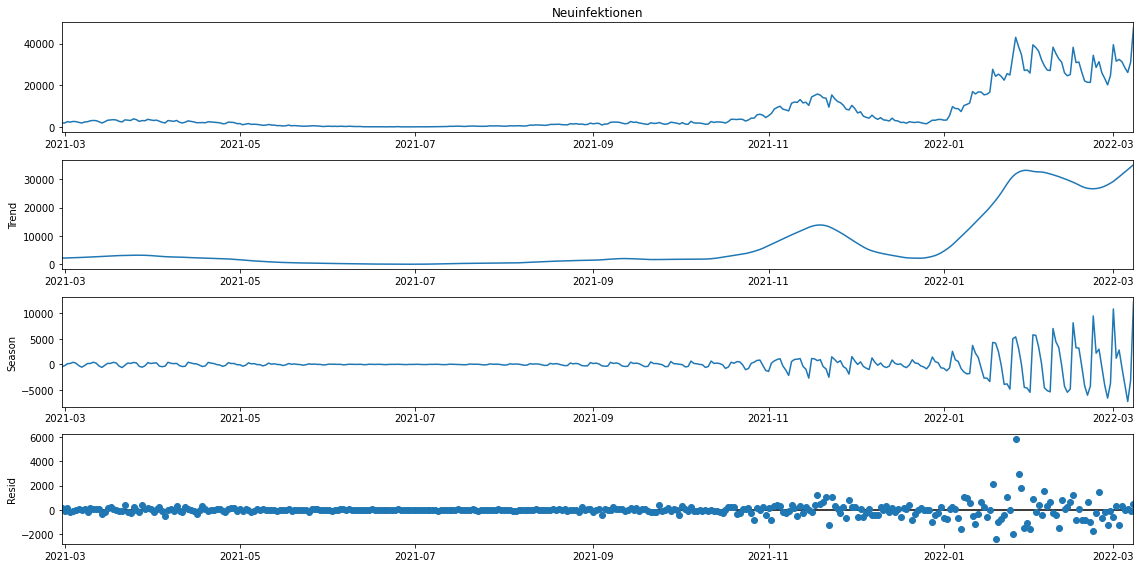

In [6]:
decomposed = STL(data.loc[data["Name"] == "Österreich", "Neuinfektionen"], period=7).fit()
plt.rc("figure", figsize=(16, 8))
decomposed.plot()
plt.show()


### Neuinfektionen (Vorausberechnung)

In [7]:
infektionen = data.loc[data["Name"] == "Österreich", "Neuinfektionen"].tail(15)
fcst = STLForecast(infektionen, ARIMA, period=7, model_kwargs={"order": (2, 1, 0)}).fit().forecast(7)
pd.DataFrame(fcst.apply(lambda x: f'{x:,.0f}'.replace(",", " ")), columns = ["Neuinfektionen"])

C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,Neuinfektionen
2022-03-09,36 720
2022-03-10,37 095
2022-03-11,35 308
2022-03-12,31 795
2022-03-13,28 753
2022-03-14,32 793
2022-03-15,48 553


## Hospitalisierung
### Werte der letzten 7 Tage

In [8]:
hosp = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "Hospitalisierung": data.tail(7*10)["Hospitalisierung"],
        "Diff": data.tail(7*10)["HospitalisierungDiff"],
    }
)
hosp["HospitalisierungPrint"] = hosp.apply(lambda x: f'{x.Hospitalisierung:,.0f} ({x.Diff:,.0f})'.replace(",", " "), axis=1)
hosp.pivot(values="HospitalisierungPrint", columns="Name")


Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-03-02,83 (-4),207 (-7),456 (-14),394 (-9),101 (-9),381 (2),263 (-6),78 (6),636 (18),2 599 (-23)
2022-03-03,83 (0),192 (-15),464 (8),385 (-9),107 (6),378 (-3),238 (-25),75 (-3),625 (-11),2 547 (-52)
2022-03-04,83 (0),190 (-2),476 (12),391 (6),95 (-12),373 (-5),243 (5),75 (0),621 (-4),2 547 (0)
2022-03-05,91 (8),190 (0),430 (-46),406 (15),85 (-10),382 (9),224 (-19),68 (-7),593 (-28),2 469 (-78)
2022-03-06,99 (8),190 (0),471 (41),430 (24),88 (3),391 (9),228 (4),73 (5),622 (29),2 592 (123)
2022-03-07,103 (4),207 (17),508 (37),462 (32),106 (18),411 (20),255 (27),79 (6),629 (7),2 760 (168)
2022-03-08,104 (1),205 (-2),500 (-8),429 (-33),111 (5),443 (32),245 (-10),73 (-6),654 (25),2 764 (4)


### Diagramm

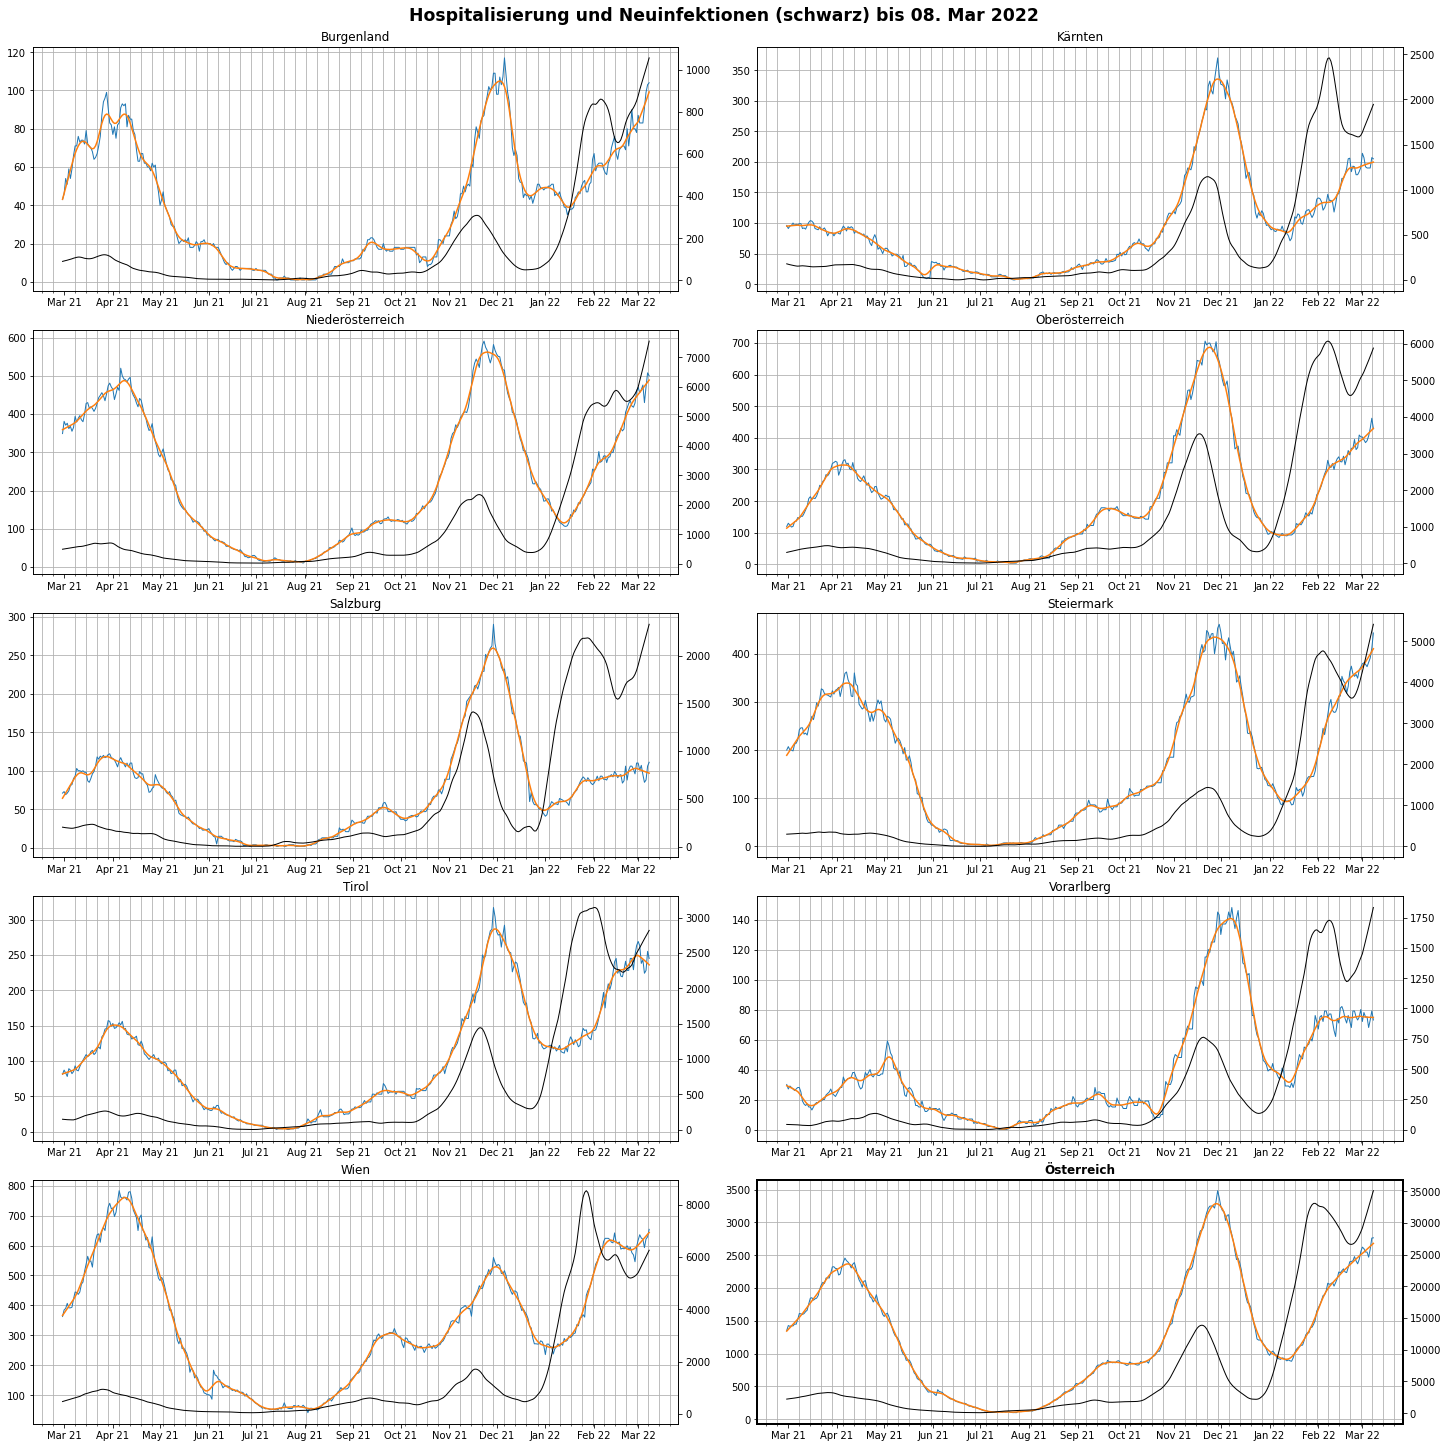

In [9]:

plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz)", data)


### Logarithmischer Plot

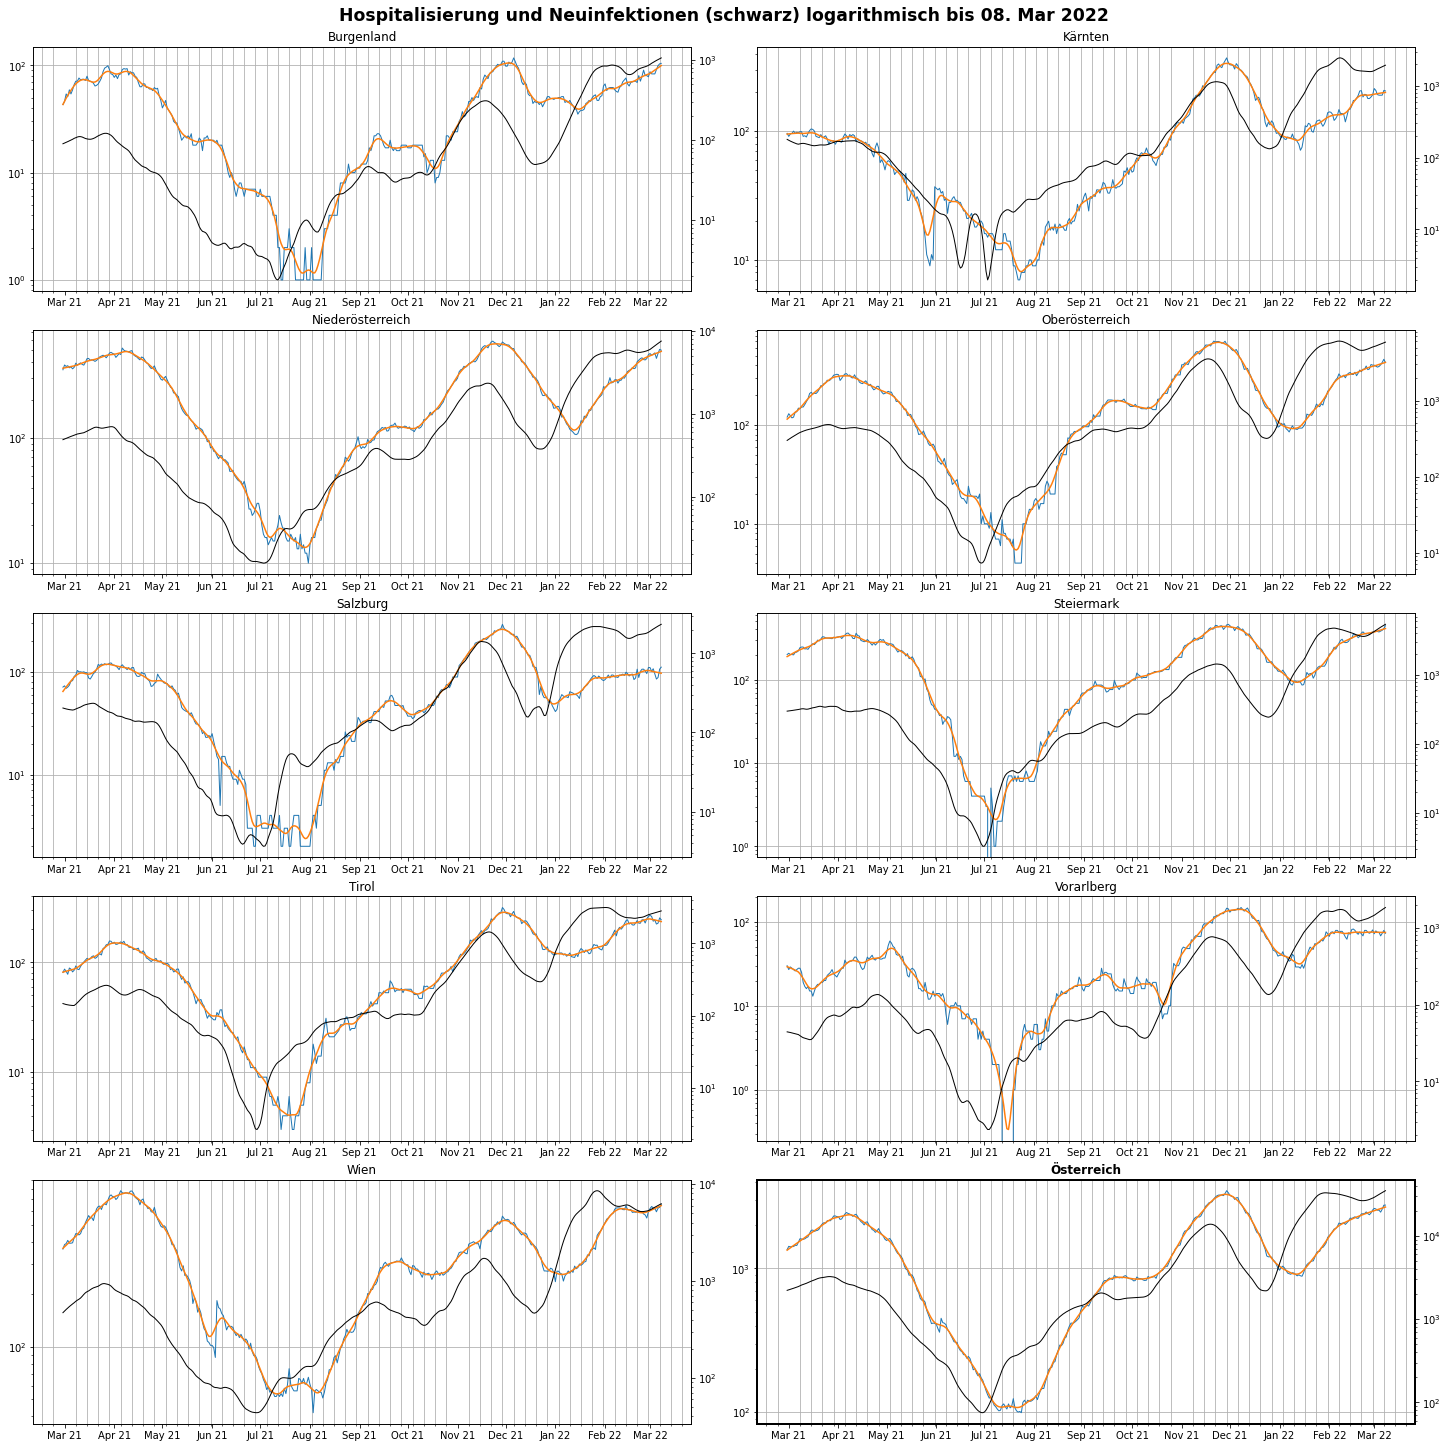

In [10]:
plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz) logarithmisch", data, log=True)

## Durchgeführte PCR Tests
### Werte der letzten 7 Tage

In [11]:
pcrTaeglich = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "TestungenPCR": data.tail(7*10)["TestungenPCR"],
        "Diff": data.tail(8*10)["TestungenPCR"].diff(periods=10).tail(7*10)
    }
)
pcrTaeglich["TestungenPrint"] = pcrTaeglich.apply(lambda x: f'{x.TestungenPCR:,.0f} ({x.Diff:,.0f})'.replace(",", " "), axis=1)
pcrTaeglich.pivot(values="TestungenPrint", columns="Name")

Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-03-02,11 351 (4 647),7 445 (575),37 737 (-108 298),27 757 (5 508),12 379 (-1 934),23 637 (-4 746),18 975 (2 000),7 133 (-665),240 133 (-95 928),386 547 (-198 841)
2022-03-03,9 002 (-2 349),3 687 (-3 758),25 995 (-11 742),32 161 (4 404),12 730 (351),23 740 (103),16 371 (-2 604),6 343 (-790),29 366 (-210 767),159 395 (-227 152)
2022-03-04,9 710 (708),6 559 (2 872),294 882 (268 887),25 430 (-6 731),10 965 (-1 765),21 533 (-2 207),16 855 (484),6 631 (288),380 501 (351 135),773 066 (613 671)
2022-03-05,9 637 (-73),4 150 (-2 409),29 024 (-265 858),23 340 (-2 090),9 965 (-1 000),24 607 (3 074),14 507 (-2 348),5 871 (-760),155 218 (-225 283),276 319 (-496 747)
2022-03-06,8 490 (-1 147),2 876 (-1 274),33 199 (4 175),21 888 (-1 452),8 892 (-1 073),17 602 (-7 005),9 585 (-4 922),6 485 (614),43 010 (-112 208),152 027 (-124 292)
2022-03-07,5 905 (-2 585),3 761 (885),33 498 (299),32 488 (10 600),9 488 (596),22 353 (4 751),22 226 (12 641),7 114 (629),398 950 (355 940),535 783 (383 756)
2022-03-08,7 687 (1 782),6 362 (2 601),27 440 (-6 058),25 719 (-6 769),11 469 (1 981),29 412 (7 059),16 492 (-5 734),7 652 (538),338 089 (-60 861),470 322 (-65 461)


### Diagramm

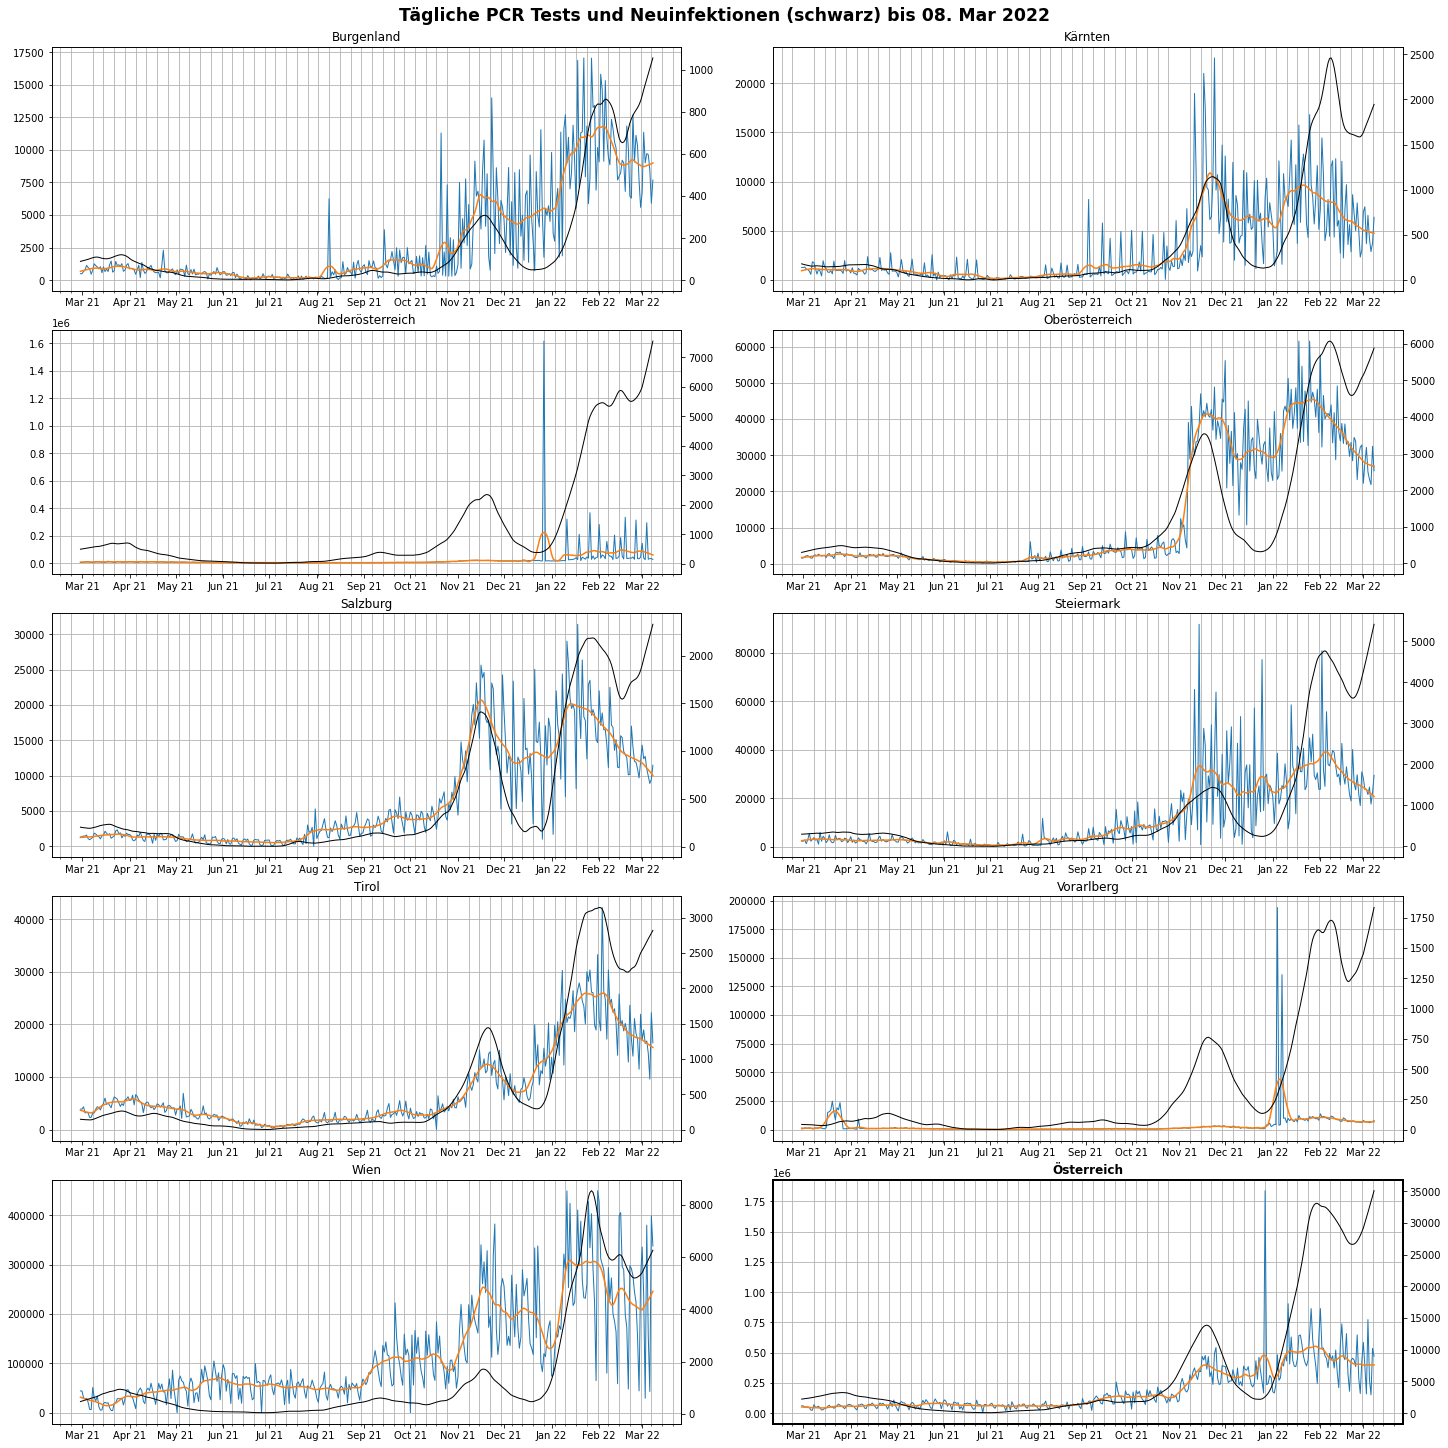

In [12]:
plot_param(["TestungenPCR", "Neuinfektionen"], "Tägliche PCR Tests und Neuinfektionen (schwarz)", data)